# Integrated vorticity flux and vorticity

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import lines
import cmocean
from scipy.stats import pearsonr

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.cursive'] = ['Helvetica-Oblique']
plt.rcParams['pdf.fonttype'] = 42

In [2]:
ds = xr.open_dataset("../lg2data.nc")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


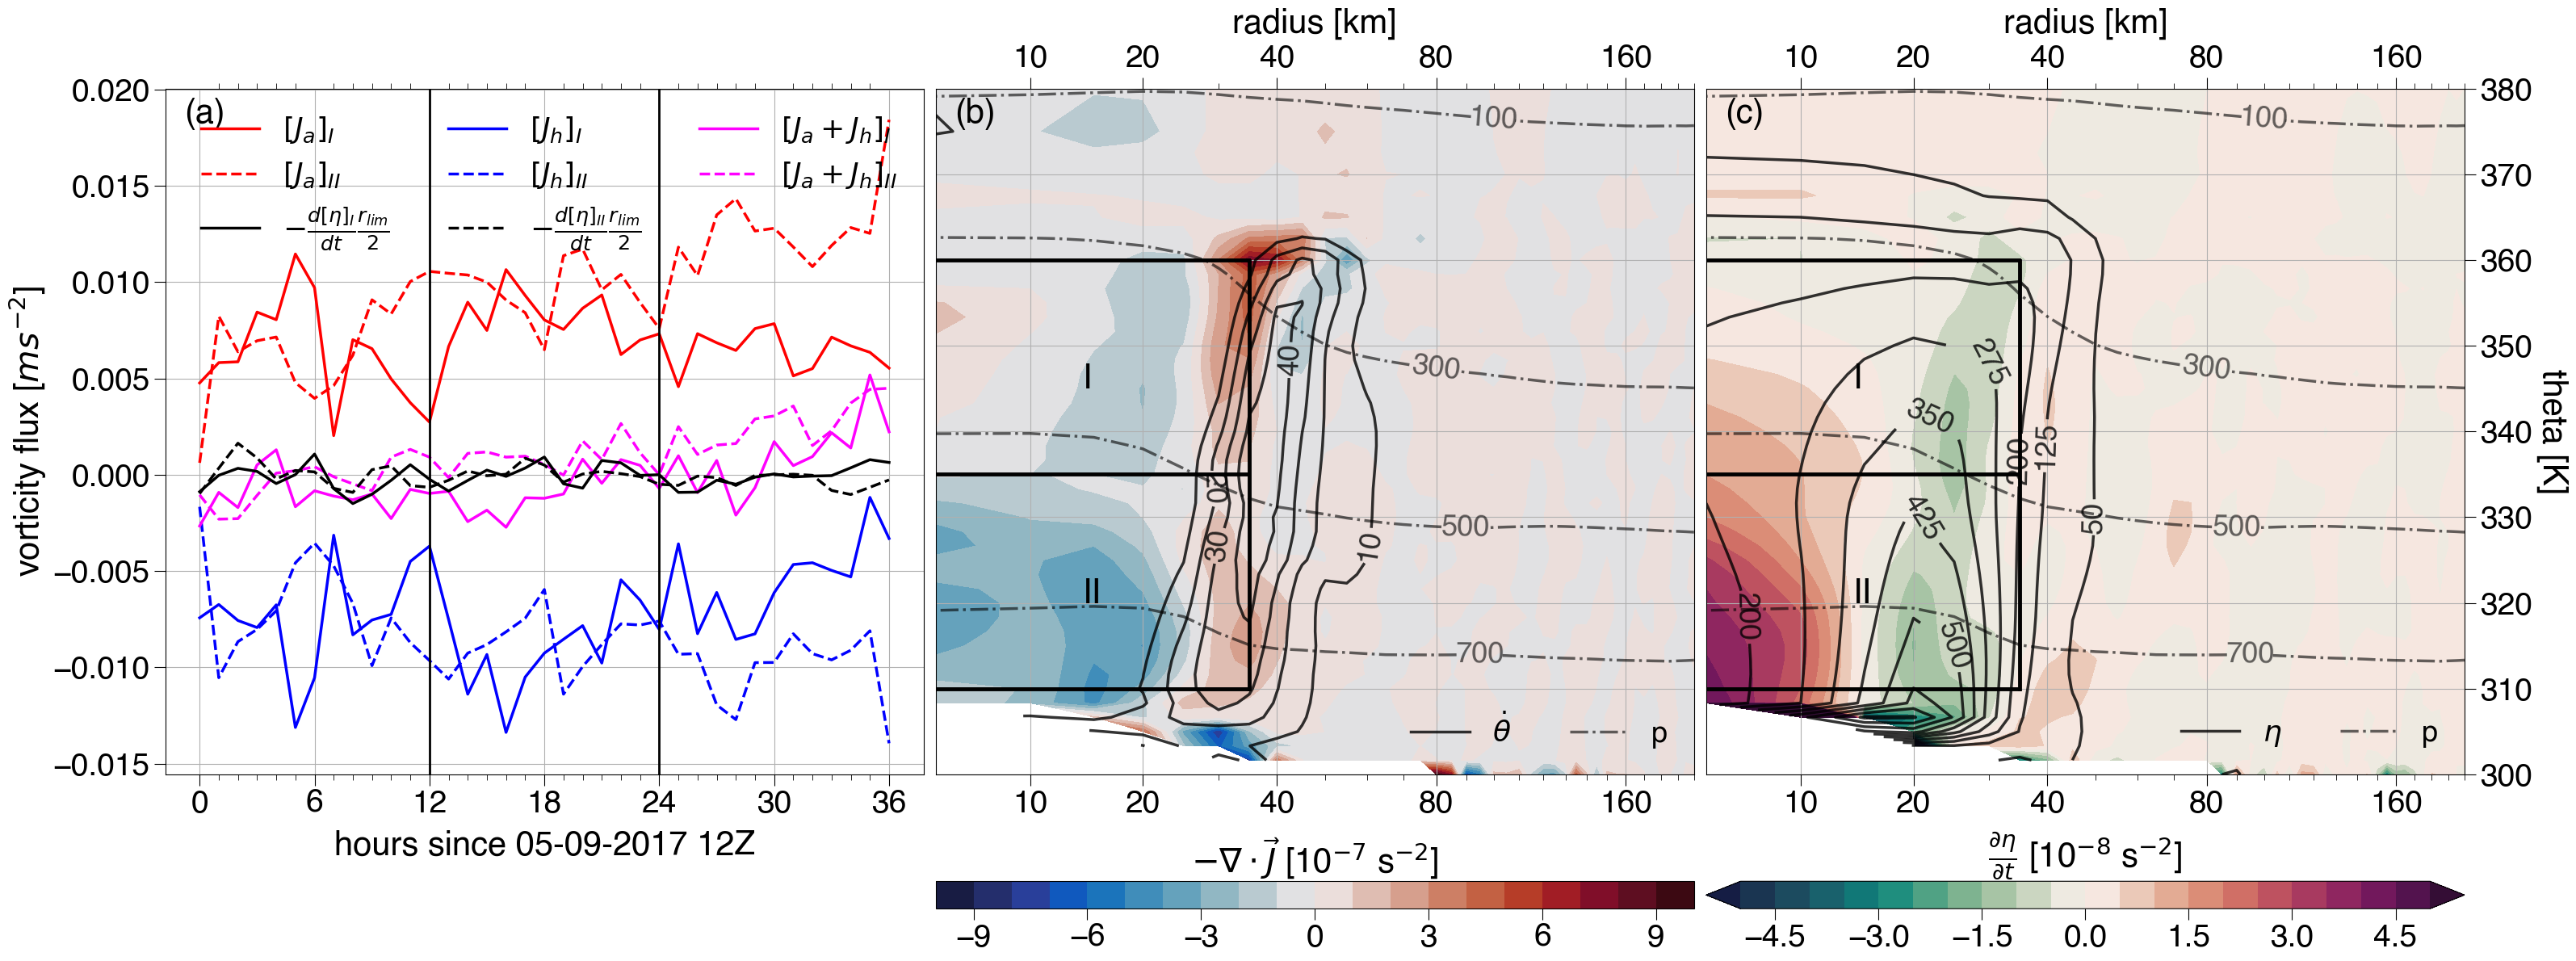

In [3]:
rz_range = {'r':slice(5000,200000), 'z':slice(3,47)}

# calculations
ds['detadt'] = ds.eta.differentiate('valid_time', datetime_unit='s')
ds['heating'] = ds.cimf / ds.sigma
dsls = ds.isel(valid_time=range(12,25)).mean('valid_time').astype('float64').sel(rz_range)
mask = dsls.Jh.isnull()
dsls = dsls.where(~mask, np.nan)
ds1 = ds.sel(r=35000,z=slice(24,40)) # 335 - 360 K
ds2 = ds.sel(r=35000,z=slice(9,25))  # 310 - 335 K
ds1f = ds.sel(r=slice(0,35000),z=slice(24,40))
ds2f = ds.sel(r=slice(0,35000),z=slice(9,25))
ds1f = ds1f.weighted(ds1f.r).mean('r')
ds2f = ds2f.weighted(ds2f.r).mean('r')
wmean = lambda da: da.weighted(da.theta.differentiate('z')).mean('z')

# general properties
xticks = np.array([10,20,40,80,160]) * 1000
xticklabels = ['10','20','40','80','160']
xticksminor = np.arange(10,201,10) * 1000
tticks = np.arange(0,37,6)
tticksminor = np.arange(0,37,1)
ticklabelsize = 28
ticklength = 10
minorticklength = 5
labelsize = 30
clabelsize = 26
linewidth = 2.5
Jlevels = np.arange(-0.0065,0.00651,0.0001)*1e-4
Jsumlevels = np.arange(-0.95,1.0, .1)
Vlevels = np.arange(0,80,10)
etalevels = [25,50,100,200,300,400,500,600,700,800]
etalevels = np.arange(50,801,75)
Ulevels = [-17.5,-12.5,-7.5,-2.5,2.5,7.5,12.5,17.5]
Plevels = np.array([100,300,500,700])

# create subplots
fig, ax = plt.subplots(ncols=3, nrows=2, height_ratios=[25,1], figsize=(32,12))
ax1 = ax[0,0] # Flux integral
ax2 = ax[0,1] # Flux divergence
ax3 = ax[0,2] # Tendency
ax4 = ax[1,1] # Divergence colorbar
ax5 = ax[1,2] # Tendency colorbar
ax[1,0].axis('off')

# Plot 1
time = (ds1.valid_time - ds1.valid_time[0])/3.6e12
p10 = ax1.plot(time, wmean(ds1.Ja), color='r', linewidth=linewidth)
p11 = ax1.plot(time, wmean(ds2.Ja), color='r', linewidth=linewidth, linestyle='--')
p12 = ax1.plot(time, wmean(ds1.Jh), color='b', linewidth=linewidth)
p13 = ax1.plot(time, wmean(ds2.Jh), color='b', linewidth=linewidth, linestyle='--')
p14 = ax1.plot(time, wmean(ds1.Ja+ds1.Jh), color='magenta', linewidth=linewidth)
p15 = ax1.plot(time, wmean(ds2.Ja+ds2.Jh), color='magenta', linewidth=linewidth, linestyle='--')
p16 = ax1.plot(time, -(wmean(ds1.detadt)*35000/2), color='k', linewidth=linewidth)
p17 = ax1.plot(time, -(wmean(ds2.detadt)*35000/2), color='k', linewidth=linewidth,linestyle='--')
p18 = ax1.axvline(12, color='k', lw=2)
p19 = ax1.axvline(24, color='k', lw=2)

# Plot 2
p2 = (-(dsls.r*(dsls.Ja+dsls.Jh+dsls.Je)).differentiate('r')/(1e-7*dsls.r)).transpose('z','r').plot.contourf(ax=ax2, add_colorbar=False, levels=21, y='theta', cmap=cmocean.cm.balance)
#p21 = dsls.v_tan.plot.contour(ax=ax2, levels=Vlevels, y='theta', colors='r', alpha=0.8, linewidths=linewidth)
p22 = (dsls.heating*3600).where(~np.isnan(dsls.Je),np.nan).plot.contour(ax=ax2, levels=np.arange(10,61,10), y='theta', colors='k', alpha=0.8, linewidths=linewidth)
p23 = (dsls.pres/100).plot.contour(ax=ax2, levels=Plevels, y='theta', colors='k', zorder=5, linewidths=linewidth, alpha=0.6, linestyles='dashdot')
#ax2.clabel(p21, inline=True, inline_spacing=1, fontsize=clabelsize, fmt="%d")
ax2.clabel(p22, inline=True, inline_spacing=1, fontsize=clabelsize, fmt="%1.0f")
ax2.clabel(p23,inline=True,inline_spacing=1,fontsize=clabelsize)
ax2.axhline(310, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax2.axhline(335, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax2.axhline(360, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax2.axvline(35000, ymin=0.1252, ymax=0.7492, linewidth=linewidth+1, color='k')
ax2.text(14000,345,"I", fontweight='bold', fontsize=labelsize)
ax2.text(14000,320,"II",fontweight='bold', fontsize=labelsize)

# Plot 3
p4 = (dsls.detadt/1e-8).plot.contourf(ax=ax3, add_colorbar=False, levels=np.arange(-5,5.1,0.5), y='theta', cmap=cmocean.cm.curl)
p42 = (dsls.pres/100).plot.contour(ax=ax3, levels=Plevels, y='theta', colors='k', zorder=5, linewidths=linewidth, alpha=0.6, linestyles='dashdot')
p41 = (dsls.eta/1e-5).plot.contour(ax=ax3, y='theta',levels=etalevels,linewidths=linewidth, alpha=0.8, colors='k')
ax3.clabel(p42,inline=True,inline_spacing=1,fontsize=clabelsize)
ax3.clabel(p41,inline=True,inline_spacing=1,fontsize=clabelsize)
ax3.axhline(310, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax3.axhline(335, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax3.axhline(360, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax3.axvline(35000, ymin=0.1252, ymax=0.7492, linewidth=linewidth+1, color='k')
ax3.text(14000,345,"I", fontweight='bold', fontsize=labelsize)
ax3.text(14000,320,"II",fontweight='bold', fontsize=labelsize)

# Colorbars
cb1 = plt.colorbar(p2, cax=ax4, ticks=None, orientation='horizontal')
cb2 = plt.colorbar(p4, cax=ax5, ticks=None, orientation='horizontal')

# Ticks
#ax1.set_xscale('function', functions=(lambda x: x**(1/4), lambda x: x**(4)))
ax2.set_xscale('function', functions=(lambda x: x**(1/4), lambda x: x**(4)))
ax3.set_xscale('function', functions=(lambda x: x**(1/4), lambda x: x**(4)))
ax1.set_xticks(tticks,labels=tticks)
ax2.set_xticks(xticks,labels=xticklabels)
ax3.set_xticks(xticks,labels=xticklabels)
ax1.set_xticks(tticksminor, minor=True)
ax2.set_xticks(xticksminor, minor=True)
ax3.set_xticks(xticksminor, minor=True)
ax4.minorticks_off()
ax5.minorticks_off()

# Legends
proxyartists1 = [lines.Line2D([], [], lw=p[0].get_lw(), color=p[0].get_color(), linestyle=p[0].get_linestyle(), alpha=p[0].get_alpha()) for p in [p10,p11,p16,p12,p13,p17,p14,p15]]
proxylabels1 = [r'$[J_a]_I$',r'$[J_a]_{II}$',r'$-\frac{d[\eta]_I}{dt}\frac{r_{lim}}{2}$',r'$[J_h]_I$',r'$[J_h]_{II}$',r'$-\frac{d[\eta]_{II}}{dt}\frac{r_{lim}}{2}$',r'$[J_a+J_h]_I$',r'$[J_a+J_h]_{II}$']
leg1 = ax1.legend(proxyartists1[:], proxylabels1[:], ncols=3, loc='best', framealpha=0, fontsize=clabelsize)
proxyartists2 = [lines.Line2D([], [], lw=p.linewidths, color=p.colors, linestyle=p.linestyles, alpha=p.get_alpha()) for p in [p22,p23]]
proxylabels2 = [r'$\dot{\theta}$','p']
ax2.legend(proxyartists2, proxylabels2, ncols=3, loc='lower right', framealpha=0, fontsize=clabelsize) #, bbox_to_anchor=(0.14,0.95), bbox_transform=ax2.transAxes)
proxyartists3 = [lines.Line2D([], [], lw=p.linewidths, color=p.colors, linestyle=p.linestyles, alpha=p.get_alpha()) for p in [p41,p42]]
proxylabels3 = [r'$\eta$','p']
ax3.legend(proxyartists3, proxylabels3, ncols=3, loc='lower right', framealpha=0, fontsize=clabelsize) #, bbox_to_anchor=(1,0.95), bbox_transform=ax3.transAxes)


# axis labels
ax1.set_ylabel(r'vorticity flux [$ms^{-2}$]', fontsize=labelsize)
ax2.set_ylabel('', fontsize=labelsize)
ax3.set_ylabel('theta [K]', fontsize=labelsize, rotation=270, labelpad=labelsize+2)
ax3.yaxis.set_label_position("right")
ax1.set_xlabel('hours since 05-09-2017 12Z', fontsize=labelsize, labelpad=10)
ax2.set_xlabel('radius [km]', fontsize=labelsize, labelpad=10)
ax3.set_xlabel('radius [km]', fontsize=labelsize, labelpad=10)
#ax1.xaxis.set_label_position("top")
ax2.xaxis.set_label_position("top")
ax3.xaxis.set_label_position("top")
ax1.tick_params(labelbottom=True, bottom=True, labelright=False, labelleft=True, labeltop=False, top=False, labelsize=ticklabelsize, length=ticklength)
ax2.tick_params(labelbottom=True, labelright=False, labelleft=False, labeltop=True, top=True, left=False, labelsize=ticklabelsize, length=ticklength)
ax3.tick_params(labelbottom=True, labelright=True, labelleft=False, labeltop=True, top=True, left=False, right=True, labelsize=ticklabelsize, length=ticklength)
ax4.tick_params(labelbottom=True, labelright=False, labelleft=False, labeltop=False, labelsize=ticklabelsize, length=ticklength)
ax5.tick_params(labelbottom=True, labelright=False, labelleft=False, labeltop=False, labelsize=ticklabelsize, length=ticklength)
ax1.tick_params(axis='x', which='minor', top=True, length=minorticklength)
ax2.tick_params(axis='x', which='minor', top=True, length=minorticklength)
ax3.tick_params(axis='x', which='minor', top=True, length=minorticklength)

# axis titles
ax1.annotate('(a)',(0.025,0.95),xycoords='axes fraction', fontsize=labelsize)
ax2.annotate('(b)',(0.025,0.95),xycoords='axes fraction', fontsize=labelsize)
ax3.annotate('(c)',(0.025,0.95),xycoords='axes fraction', fontsize=labelsize)
ax1.set_title('')
ax2.set_title('')
ax3.set_title('')
ax4.set_title(r'$-\nabla \cdot \vec{J}$ [10$^{-7}$ s$^{-2}$]', fontsize=labelsize, pad=-200)
ax5.set_title(r'$\frac{\partial \eta}{\partial t}$ [10$^{-8}$ s$^{-2}$]', fontsize=labelsize, pad=-20)

# grid lines
ax1.grid()
ax2.grid()
ax3.grid()


#ax2.axline((15000,310),(30001,310)) wspace=0.05, 

# white space
plt.subplots_adjust(hspace=0.2)
fig.tight_layout()

#fig.suptitle('Components of isentropic vorticity flux'
#          +f'\n{str(dsl.valid_time.data[0])[:-13]}-{str(dsl.valid_time.data[-1])[-18:-13]}',fontsize=26)

fig.savefig('fig07.pdf',format='pdf',dpi=300,transparent=False)

In [11]:
print(pearsonr(wmean(ds1.Ja).data, wmean(ds1.Jh).data))
print(pearsonr(wmean(ds2.Ja).data, wmean(ds2.Jh).data))

PearsonRResult(statistic=-0.800750948385052, pvalue=2.671967442982362e-09)
PearsonRResult(statistic=-0.88564974049774, pvalue=3.281620145641498e-13)


In [16]:
print(pearsonr(wmean(((dsls.r*(dsls.Ja+dsls.Jh+dsls.Je)).differentiate('r')/(1e-7*dsls.r))).data, wmean(dsls.detadt).data))
print(pearsonr(wmean(ds2.Ja+ds2.Jh).data, wmean(ds2.detadt).data))

PearsonRResult(statistic=0.27424420496617447, pvalue=0.08680851837950665)
PearsonRResult(statistic=0.3653195902137031, pvalue=0.02619151088265187)


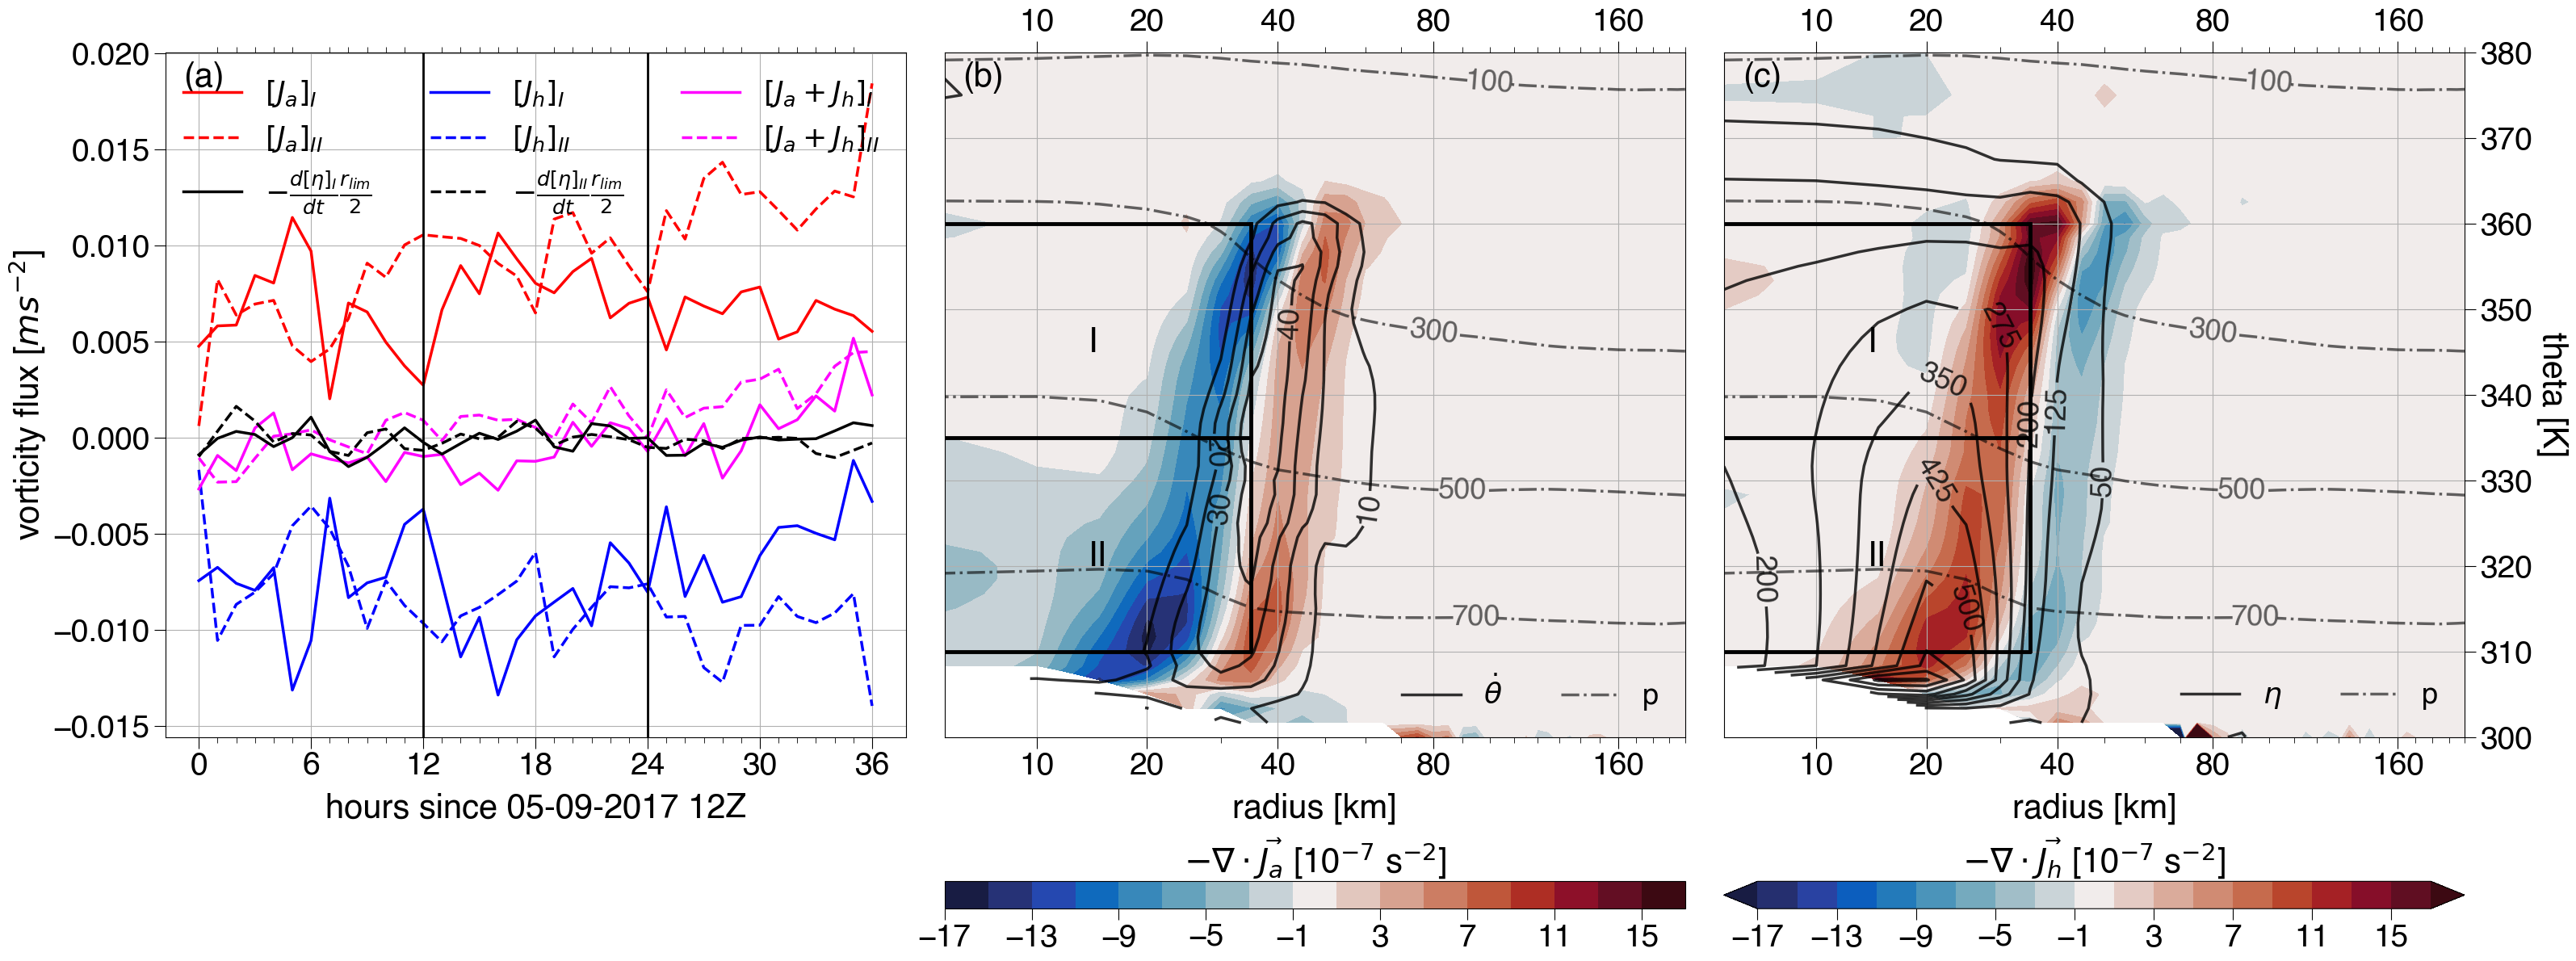

In [42]:
rz_range = {'r':slice(5000,200000), 'z':slice(3,47)}

# calculations
ds['detadt'] = ds.eta.differentiate('valid_time', datetime_unit='s')
ds['heating'] = ds.cimf / ds.sigma
dsls = ds.isel(valid_time=range(12,25)).mean('valid_time').astype('float64').sel(rz_range)
mask = dsls.Jh.isnull()
dsls = dsls.where(~mask, np.nan)
ds1 = ds.sel(r=35000,z=slice(24,40)) # 335 - 360 K
ds2 = ds.sel(r=35000,z=slice(9,25))  # 310 - 335 K
ds1f = ds.sel(r=slice(0,35000),z=slice(24,40))
ds2f = ds.sel(r=slice(0,35000),z=slice(9,25))
ds1f = ds1f.weighted(ds1f.r).mean('r')
ds2f = ds2f.weighted(ds2f.r).mean('r')
wmean = lambda da: da.weighted(da.theta.differentiate('z')).mean('z')

# general properties
xticks = np.array([10,20,40,80,160]) * 1000
xticklabels = ['10','20','40','80','160']
xticksminor = np.arange(10,201,10) * 1000
tticks = np.arange(0,37,6)
tticksminor = np.arange(0,37,1)
ticklabelsize = 28
ticklength = 10
minorticklength = 5
labelsize = 30
clabelsize = 26
linewidth = 2.5
Jlevels = np.arange(-0.0065,0.00651,0.0001)*1e-4
Jsumlevels = np.arange(-0.95,1.0, .1)
Vlevels = np.arange(0,80,10)
etalevels = [25,50,100,200,300,400,500,600,700,800]
etalevels = np.arange(50,801,75)
Ulevels = [-17.5,-12.5,-7.5,-2.5,2.5,7.5,12.5,17.5]
Plevels = np.array([100,300,500,700])

# create subplots
fig, ax = plt.subplots(ncols=3, nrows=2, height_ratios=[25,1], figsize=(32,12))
ax1 = ax[0,0] # Flux integral
ax2 = ax[0,1] # Flux divergence
ax3 = ax[0,2] # Tendency
ax4 = ax[1,1] # Divergence colorbar
ax5 = ax[1,2] # Tendency colorbar
ax[1,0].axis('off')

# ax4.axis('off')
# ax5.axis('off')

# Plot 1
time = (ds1.valid_time - ds1.valid_time[0])/3.6e12
p10 = ax1.plot(time, wmean(ds1.Ja), color='r', linewidth=linewidth)
p11 = ax1.plot(time, wmean(ds2.Ja), color='r', linewidth=linewidth, linestyle='--')
p12 = ax1.plot(time, wmean(ds1.Jh), color='b', linewidth=linewidth)
p13 = ax1.plot(time, wmean(ds2.Jh), color='b', linewidth=linewidth, linestyle='--')
p14 = ax1.plot(time, wmean(ds1.Ja+ds1.Jh), color='magenta', linewidth=linewidth)
p15 = ax1.plot(time, wmean(ds2.Ja+ds2.Jh), color='magenta', linewidth=linewidth, linestyle='--')
p16 = ax1.plot(time, -(wmean(ds1.detadt)*35000/2), color='k', linewidth=linewidth)
p17 = ax1.plot(time, -(wmean(ds2.detadt)*35000/2), color='k', linewidth=linewidth,linestyle='--')
p18 = ax1.axvline(12, color='k', lw=2)
p19 = ax1.axvline(24, color='k', lw=2)

# Plot 2
p2 = (-(dsls.r*dsls.Ja).differentiate('r')/(1e-7*dsls.r)).transpose('z','r').plot.contourf(ax=ax2, add_colorbar=False, levels=18, vmin=-17, vmax=17, y='theta', cmap=cmocean.cm.balance)
#p21 = dsls.v_tan.plot.contour(ax=ax2, levels=Vlevels, y='theta', colors='r', alpha=0.8, linewidths=linewidth)
p22 = (dsls.heating*3600).where(~np.isnan(dsls.Je),np.nan).plot.contour(ax=ax2, levels=np.arange(10,61,10), y='theta', colors='k', alpha=0.8, linewidths=linewidth)
p23 = (dsls.pres/100).plot.contour(ax=ax2, levels=Plevels, y='theta', colors='k', zorder=5, linewidths=linewidth, alpha=0.6, linestyles='dashdot')
#ax2.clabel(p21, inline=True, inline_spacing=1, fontsize=clabelsize, fmt="%d")
ax2.clabel(p22, inline=True, inline_spacing=1, fontsize=clabelsize, fmt="%1.0f")
ax2.clabel(p23,inline=True,inline_spacing=1,fontsize=clabelsize)
ax2.axhline(310, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax2.axhline(335, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax2.axhline(360, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax2.axvline(35000, ymin=0.1252, ymax=0.7492, linewidth=linewidth+1, color='k')
ax2.text(14000,345,"I", fontweight='bold', fontsize=labelsize)
ax2.text(14000,320,"II",fontweight='bold', fontsize=labelsize)

# Plot 3
p4 = (-(dsls.r*dsls.Jh).differentiate('r')/(1e-7*dsls.r)).transpose('z','r').plot.contourf(ax=ax3, add_colorbar=False, levels=18, vmin=-17, vmax=17, y='theta', cmap=cmocean.cm.balance)
p42 = (dsls.pres/100).plot.contour(ax=ax3, levels=Plevels, y='theta', colors='k', zorder=5, linewidths=linewidth, alpha=0.6, linestyles='dashdot')
p41 = (dsls.eta/1e-5).plot.contour(ax=ax3, y='theta',levels=etalevels,linewidths=linewidth, alpha=0.8, colors='k')
ax3.clabel(p42,inline=True,inline_spacing=1,fontsize=clabelsize)
ax3.clabel(p41,inline=True,inline_spacing=1,fontsize=clabelsize)
ax3.axhline(310, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax3.axhline(335, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax3.axhline(360, xmin=0, xmax=0.412, linewidth=linewidth+1, color='k')
ax3.axvline(35000, ymin=0.1252, ymax=0.7492, linewidth=linewidth+1, color='k')
ax3.text(14000,345,"I", fontweight='bold', fontsize=labelsize)
ax3.text(14000,320,"II",fontweight='bold', fontsize=labelsize)

# Colorbars
cb1 = plt.colorbar(p2, cax=ax4, ticks=None, orientation='horizontal')
cb2 = plt.colorbar(p4, cax=ax5, ticks=None, orientation='horizontal')

# Ticks
#ax1.set_xscale('function', functions=(lambda x: x**(1/4), lambda x: x**(4)))
ax2.set_xscale('function', functions=(lambda x: x**(1/4), lambda x: x**(4)))
ax3.set_xscale('function', functions=(lambda x: x**(1/4), lambda x: x**(4)))
ax1.set_xticks(tticks,labels=tticks)
ax2.set_xticks(xticks,labels=xticklabels)
ax3.set_xticks(xticks,labels=xticklabels)
ax1.set_xticks(tticksminor, minor=True)
ax2.set_xticks(xticksminor, minor=True)
ax3.set_xticks(xticksminor, minor=True)
ax4.minorticks_off()
ax5.minorticks_off()

# Legends
proxyartists1 = [lines.Line2D([], [], lw=p[0].get_lw(), color=p[0].get_color(), linestyle=p[0].get_linestyle(), alpha=p[0].get_alpha()) for p in [p10,p11,p16,p12,p13,p17,p14,p15]]
proxylabels1 = [r'$[J_a]_I$',r'$[J_a]_{II}$',r'$-\frac{d[\eta]_I}{dt}\frac{r_{lim}}{2}$',r'$[J_h]_I$',r'$[J_h]_{II}$',r'$-\frac{d[\eta]_{II}}{dt}\frac{r_{lim}}{2}$',r'$[J_a+J_h]_I$',r'$[J_a+J_h]_{II}$']
leg1 = ax1.legend(proxyartists1[:], proxylabels1[:], ncols=3, loc='best', framealpha=0, fontsize=clabelsize)
proxyartists2 = [lines.Line2D([], [], lw=p.linewidths, color=p.colors, linestyle=p.linestyles, alpha=p.get_alpha()) for p in [p22,p23]]
proxylabels2 = [r'$\dot{\theta}$','p']
ax2.legend(proxyartists2, proxylabels2, ncols=3, loc='lower right', framealpha=0, fontsize=clabelsize) #, bbox_to_anchor=(0.14,0.95), bbox_transform=ax2.transAxes)
proxyartists3 = [lines.Line2D([], [], lw=p.linewidths, color=p.colors, linestyle=p.linestyles, alpha=p.get_alpha()) for p in [p41,p42]]
proxylabels3 = [r'$\eta$','p']
ax3.legend(proxyartists3, proxylabels3, ncols=3, loc='lower right', framealpha=0, fontsize=clabelsize) #, bbox_to_anchor=(1,0.95), bbox_transform=ax3.transAxes)


# axis labels
ax1.set_ylabel(r'vorticity flux [$ms^{-2}$]', fontsize=labelsize)
ax2.set_ylabel('', fontsize=labelsize)
ax3.set_ylabel('theta [K]', fontsize=labelsize, rotation=270, labelpad=labelsize+2)
ax3.yaxis.set_label_position("right")
ax1.set_xlabel('hours since 05-09-2017 12Z', fontsize=labelsize, labelpad=10)
ax2.set_xlabel('radius [km]', fontsize=labelsize, labelpad=10)
ax3.set_xlabel('radius [km]', fontsize=labelsize, labelpad=10)
#ax1.xaxis.set_label_position("top")
#ax2.xaxis.set_label_position("top")
#ax3.xaxis.set_label_position("top")
ax1.tick_params(labelbottom=True, bottom=True, labelright=False, labelleft=True, labeltop=False, top=False, labelsize=ticklabelsize, length=ticklength)
ax2.tick_params(labelbottom=True, labelright=False, labelleft=False, labeltop=True, top=True, left=False, labelsize=ticklabelsize, length=ticklength)
ax3.tick_params(labelbottom=True, labelright=True, labelleft=False, labeltop=True, top=True, left=False, right=True, labelsize=ticklabelsize, length=ticklength)
ax4.tick_params(labelbottom=True, labelright=False, labelleft=False, labeltop=False, labelsize=ticklabelsize, length=ticklength)
ax5.tick_params(labelbottom=True, labelright=False, labelleft=False, labeltop=False, labelsize=ticklabelsize, length=ticklength)
ax1.tick_params(axis='x', which='minor', top=True, length=minorticklength)
ax2.tick_params(axis='x', which='minor', top=True, length=minorticklength)
ax3.tick_params(axis='x', which='minor', top=True, length=minorticklength)

# axis titles
ax1.annotate('(a)',(0.025,0.95),xycoords='axes fraction', fontsize=labelsize)
ax2.annotate('(b)',(0.025,0.95),xycoords='axes fraction', fontsize=labelsize)
ax3.annotate('(c)',(0.025,0.95),xycoords='axes fraction', fontsize=labelsize)
ax1.set_title('')
ax2.set_title('')
ax3.set_title('')
ax4.set_title(r'$-\nabla \cdot \vec{J_a}$ [10$^{-7}$ s$^{-2}$]', fontsize=labelsize, pad=-200)
ax5.set_title(r'$-\nabla \cdot \vec{J_h}$ [10$^{-7}$ s$^{-2}$]', fontsize=labelsize, pad=-20)

# grid lines
ax1.grid()
ax2.grid()
ax3.grid()


# ax2.set_title(r'$-\nabla\cdot\vec{J_a}$', fontsize=labelsize)
# ax3.set_title(r'$-\nabla\cdot\vec{J_h}$', fontsize=labelsize)
#ax2.axline((15000,310),(30001,310)) wspace=0.05, 

# white space
plt.subplots_adjust(hspace=0.2)
fig.tight_layout()

#fig.suptitle('Components of isentropic vorticity flux'
#          +f'\n{str(dsl.valid_time.data[0])[:-13]}-{str(dsl.valid_time.data[-1])[-18:-13]}',fontsize=26)